# MLF Final Project:

$$\textbf{Quantitative Trading via Machine Learning in the
Chinese Stock Market}$$

**Author:** Bo Sun, Xinran Guo

## Content

- [Introduction](#Introduction) 
- [Part I: Data Collection](#Part-I:-Data-Collection)  
- [Part II: Data Processing](#Part-II:-Data-Processing)
- [Part III: Baseline Model](#Part-III:-Baseline-Model)
- [Part IV: Feature Engineering](#Part-IV:-Feature-Engineering)  
- [Part V: Neural Network Architecture](#Part-V:-Neural-Network-Architecture)

## Introduction

*This project comes from the inspiration of [this report](华泰人工智能系列三十二：alphanet：因子挖掘神经网络_2020-06-15_华泰证券.pdf).*

With multi-dimensional data on equity trading, quantitative traders have troubles finding the dominating factors for investment decision. Two-dimensional Convolutional Neural Network (2d-CNN) is able to extract features from data matrix. Therefore, 2d-CNN seems to be a feasible model to find investment factors. In this project, we intend to carry out and evaluate this strategy using Chinese A-share stocks. After specifying model structure (see figure 2), we train our model with historical stock data and conduct backtesting on rolling basis (see figure 1).

<img src="https://z3.ax1x.com/2021/06/22/RezGjA.png" style="" width="500">

<img src="https://z3.ax1x.com/2021/06/22/Rez534.png" style="" width="600">

where BN represents Batch Normalization.

## Part I: Data Collection

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy as sa
import os
import configparser
import time
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

Here is our data collection process. Since PHBS has a Oracle database for A share stock price, our goal is to get data from this database. Then:

- First we read from database.ini containing info of the database and use keys.
- Second we write queries to read data from Oracle database month by month (since there is a limit for query data size)
- Third we concatenate monthly data and save it as a parquet file.

Unfortunately the database is only available in the PHBS builing, so we put our code here (they are only supposed to work within intranet) and save the data as a parquet file. Then everybody should be able to load the data from parquet file.

In [27]:
# Load database.ini to get configuration to connect Oracle database
def read_db_config(ini_file='database.ini', section='WIND'):
    """
    read database.ini
    """  
    if not os.path.exists(ini_file):
        raise IOError('File not exist[%s]' %config_file)
        
    config = configparser.ConfigParser()
    config.read(ini_file, encoding='utf-8')  
    db_config = {}
    if section in config.sections():
        db_config = dict(config._sections[section])
    else:
        print('Section not exist：' + section)
                
    return db_config

# get configuration
config = read_db_config()
# create connection to database
eng = sa.create_engine(('{dbtype}://{user}:{password}@{host}:{port}/'
                   '{sid}').format(**config))

In [ ]:
# Load market data from Filesync database
marketdata = pd.DataFrame()

# Read in a monthly frequency
datearr = pd.date_range('2009-12-31','2020-12-31',freq='M')

for i in tqdm(range(len(datearr)-1)):
    # begin date and end date
    lastmonthday = datearr[i].strftime("%Y%m%d")
    thismonthday = datearr[i+1].strftime("%Y%m%d")
    # query 1: price info
    query1 = """
        SELECT 
        S_INFO_WINDCODE,
        TRADE_DT,
        S_DQ_OPEN,
        S_DQ_HIGH，
        S_DQ_LOW，
        S_DQ_CLOSE，
        S_DQ_PCTCHANGE，
        S_DQ_VOLUME，
        S_DQ_AMOUNT，
        S_DQ_AVGPRICE，
        S_DQ_ADJFACTOR
        FROM FILESYNC.AShareEODPrices where
        TRADE_DT > '%s' and TRADE_DT <= '%s'
        """ % (lastmonthday,thismonthday)
    data1 = pd.read_sql(query1,eng)
    # query 2: derivative info
    query2 = """
        SELECT 
        S_INFO_WINDCODE,
        TRADE_DT,
        S_DQ_TURN,
        S_DQ_FREETURNOVER,
        UP_DOWN_LIMIT_STATUS
        FROM FILESYNC.AShareEODDerivativeIndicator where
        TRADE_DT > '%s' and TRADE_DT <= '%s'
        """ % (lastmonthday,thismonthday)
    data2 = pd.read_sql(query2,eng)
    # merge together
    data1 = pd.merge(data1,data2,how='left',on=['s_info_windcode','trade_dt'])
    marketdata = pd.concat([marketdata,data1])
    # sleep for 5 seconds to release database
    time.sleep(5)

We also need some extra data.

First is the ST stocks, where ST stands for "Special Treatment".The Shanghai and Shenzhen Stock Exchange conduct special treatment on the stock transactions of listed companies with abnormal financial conditions or other conditions, and prefix them with "ST" in front of the abbreviation, so such stocks are called ST stocks.

We will exclude ST stocks from our portfolio because they are highly illiquid and facing great delisting risks, so we need to read them from database.

In [28]:
# get ST，*ST stock
query_st = """
    SELECT 
    S_INFO_WINDCODE,
    S_TYPE_ST,
    ENTRY_DT,
    REMOVE_DT
    FROM FILESYNC.AShareST
    """
stdata = pd.read_sql(query_st,eng)
# set current ST,*ST stock remove date to a default date
stdata.remove_dt = stdata.remove_dt.fillna('20990101')
stdata.head()

,s_info_windcode,s_type_st,entry_dt,remove_dt
0,600421.SH,S,20180111,20990101
1,002604.SZ,S,20180119,20990101
2,000410.SZ,S,20170503,20180301
3,002188.SZ,S,20180208,20990101
4,002427.SZ,S,20180208,20990101


Next, we also need information on the listing and delisting date of stocks.

China’s A-shares have a price limit system, and newly listed stocks will have consecutive up-limits for a period of time and cannot be traded.

Based on the above reason, we also exclude stocks that have been listed for less than 120 days from our portfolio.

In [29]:
# get stock listdate and delistdate
query_listdate = """
    SELECT 
    S_INFO_WINDCODE,
    S_INFO_LISTDATE,
    S_INFO_DELISTDATE
    FROM FILESYNC.AShareDescription
    """ 
listdata = pd.read_sql(query_listdate,eng)
# drop stocks that have not listed
listdata = listdata.dropna(subset=['s_info_listdate'])
# set current stock delistdate to a default date
listdata.s_info_delistdate = listdata.s_info_delistdate.fillna('20990101')
listdata.head()

,s_info_windcode,s_info_listdate,s_info_delistdate
0,300547.SZ,20160930,20990101
1,603160.SH,20161017,20990101
2,603569.SH,20160810,20990101
3,002819.SZ,20161111,20990101
4,300539.SZ,20160830,20990101


Now we will do data integration. There are 6 steps:
1. merge all data into one single DataFrame
2. create a "isst" column indicating whether a stock is in Special Treatment
3. create a "istrade" column indicating whether a stock is traded on that day
4. create a "isnew" column indicating whether a stock has been traded for at least 120 days
5. drop additional columns ,convert date string to datetime type and fill nan columns
6. save the data as a parquet file

In [14]:
# merge marketdata and listdate
data = pd.merge(marketdata,listdata,on='s_info_windcode',how='left')

# further merge with ST data
data = pd.merge(data,stdata,on='s_info_windcode',how='left')

# add column isst: whether a stock is in ST or *ST
data.entry_dt = data.entry_dt.fillna('20990101')
data.remove_dt = data.remove_dt.fillna('20000101')
data['isst'] = data.apply(lambda x:1 if (x.trade_dt>=x.entry_dt)&(x.trade_dt<=x.remove_dt) else 0,axis=1)

# drop additional columns
data = data.drop(columns=['s_info_delistdate','s_type_st','entry_dt','remove_dt'])

# rename columns to a simple version
data.columns = ['stockid','date','open','high','low','close','pct','vol','amount','vwap','adjfactor','turnover','freeturn',
                'limit','listdate','isst']

# fill nan columns
data.limit = data.limit.fillna(0)

# convert date string to datetime
data.date = pd.to_datetime(data.date)
data.listdate = pd.to_datetime(data.listdate)

# add column istrade : whether a stock is trading on that day
data['istrade'] = data.amount.apply(lambda x:1 if x>0 else 0)

# add column isnew : whether a stock has been traded for at least 120 days
data['isnew'] = 0
data.loc[data.date - data.listdate <= pd.Timedelta('120 days'),'isnew']=1

In [15]:
# save the data as a parquet file
data.to_parquet('data.parquet')

Finally we need to specify a market index as our benchmark. 

We choose The Shanghai Securities Composite Index (000001.SH) as our benchmark. Its sample stocks are all stocks listed on the Shanghai Stock Exchange, including A shares and B shares, reflecting the changes in the prices of listed stocks on the Shanghai Stock Exchange. It was officially released on July 15, 1991.

we also read the index data from PHBS database and save it as 'marketindex.parquet' file. 

In [16]:
# get market index data
query_index = """
    SELECT 
    TRADE_DT,
    S_DQ_CLOSE
    FROM FILESYNC.AIndexEODPrices
    WHERE S_INFO_WINDCODE = '000001.SH'
    AND TRADE_DT>='20100101' AND TRADE_DT<='20201231'
    """ 
indexdata = pd.read_sql(query_index,eng)

# rename columns 
indexdata.columns = ['date','close']

# convert date string to datetime
indexdata.date = pd.to_datetime(indexdata.date)

# save the data as a parquet file
indexdata.to_parquet('marketindex.parquet')

## Part II: Data Processing

In order to use CNN and LSTM model, we need to convert our data to "data pictures" that serve as training and predicting inputs. Our data pictures take the following format:

**Stock universe :** All Chinese A-share main board stocks, excluding newly-listed stocks, ST and PT stocks, and all stocks that are suspended or hit price limits in the following trading day.

**Time span :** Starting from 2011, we use past 1500 days data as input, among which 400 days are training period, and the remaining 100 days are validation periods.

**Variables :**
- return: daily return
- open, high, low, close: daily open price, highest price, lowest price, and close price
- volume: daily trading volume
- vwap: daily volume weighted average price
- turn: daily turnover rate
- free_turn: daily turnover rate of free float shares

**Input shape :** 9*30

**Labels :** standardized returns in the next two weeks (10 days)

Here is what our data pictures look like:
<img src="https://z3.ax1x.com/2021/07/23/Wymq56.png" style="" width="300">

In [2]:
# read data from parquet file
data = pd.read_parquet(r"data.parquet")

In [3]:
# calculate 10-days return
data['return'] = data.groupby('stockid').apply(lambda x:(x.open.shift(-11)/x.open.shift(-1)-1).fillna(0)) \
                    .reset_index(level=0,drop=True)
# standardize
data['return'] = data.groupby('date').apply(lambda x:((x['return']-x['return'].mean())/x['return'].std()).fillna(0)) \
                    .reset_index(level=0,drop=True)
data.head()

,stockid,date,open,high,low,close,pct,vol,amount,vwap,turnover,freeturn,adjfactor,limit,listdate,isst,istrade,isnew,return
0,000001.SZ,2010-01-04,24.52,24.58,23.68,23.71,-2.7082,241922.76,5.802495e+05,23.9849,0.8273,0.9360,35.905536,0.0,1991-04-03,0.0,1,0,-2.105863
1,000002.SZ,2010-01-04,10.85,10.87,10.60,10.60,-1.9426,969832.53,1.034345e+06,10.6652,1.0044,1.2067,110.804114,0.0,1991-01-29,0.0,1,0,-1.382315
2,000004.SZ,2010-01-04,10.00,10.00,10.00,10.00,0.0000,0.00,0.000000e+00,10.0000,0.0000,0.0000,4.063862,0.0,1991-01-14,0.0,0,0,-0.843219
3,000005.SZ,2010-01-04,6.01,6.05,5.91,5.99,-0.4983,223582.22,1.334784e+05,5.9700,2.4469,3.0649,9.267603,0.0,1990-12-10,0.0,1,0,-0.239352
4,000006.SZ,2010-01-04,11.33,11.35,11.11,11.12,-1.8535,62998.05,7.054856e+04,11.1985,1.2804,1.5873,11.023514,0.0,1992-04-27,0.0,1,0,-0.607098


The `generate_training_picture` function converts raw data into a training set.

We use last 400-day trading information to train our model, given an input date t. The outputs include training data picture array and label array containing standardized return, which should have the same length.

In [26]:
# generate training samples given the date
# all stocks, one picture every 5 days for the last 400 trading days
def generate_training_picture(data, t, gap, num):
    factor_list = ['open', 'high', 'low', 'close', 'vwap', 'vol', 'pct', 'turnover', 'freeturn']
    stock_list = data.stockid.unique()
    X = []
    Y = []
    data = data.set_index(['stockid', 'date'])
    for stockid in tqdm(stock_list):
        stockdata = data.loc[(stockid, slice(None))]
        stock_picture = stockdata[stockdata.amount > 0][factor_list].T

        datearr = stock_picture.columns
        n = len(datearr[datearr <= t])
        if n <= 30:
            continue
        narr = np.arange(n - 10, max(30, n - 10 - gap*num), -gap)
        for i in narr:
            X.append(stock_picture.iloc[:, i - 30:i].values)
            Y.append(stockdata.loc[datearr[i], 'return'])
    return np.array(X), np.array(Y)

In [33]:
X, Y = generate_training_picture(data, pd.to_datetime('2020-12-03'),5,80)
print ('Length of the data picture array: ',len(X))
print ('Length of the inputs: ',len(Y))

100%|██████████████████████████████████████████████████████████████████████████████| 4198/4198 [01:27<00:00, 48.19it/s]


Length of the data picture array:  157882
Length of the inputs:  157882


In [34]:
print ("Sample data picture: \n",X[0])

Sample data picture: 
 [[ 1.48000000e+01  1.53000000e+01  1.52200000e+01  1.59000000e+01
   1.60400000e+01  1.62000000e+01  1.65600000e+01  1.73000000e+01
   1.74800000e+01  1.76400000e+01  1.79400000e+01  1.75300000e+01
   1.82000000e+01  1.80000000e+01  1.77600000e+01  1.75400000e+01
   1.77400000e+01  1.76500000e+01  1.77100000e+01  1.83500000e+01
   1.83700000e+01  1.77100000e+01  1.76700000e+01  1.80000000e+01
   1.82000000e+01  1.78100000e+01  1.74200000e+01  1.70800000e+01
   1.73800000e+01  1.77800000e+01]
 [ 1.52700000e+01  1.55500000e+01  1.60500000e+01  1.61100000e+01
   1.61200000e+01  1.69200000e+01  1.73700000e+01  1.81000000e+01
   1.76000000e+01  1.80000000e+01  1.85000000e+01  1.87800000e+01
   1.82900000e+01  1.80000000e+01  1.79000000e+01  1.79300000e+01
   1.83600000e+01  1.80500000e+01  1.83400000e+01  1.84800000e+01
   1.85000000e+01  1.77500000e+01  1.80000000e+01  1.85000000e+01
   1.83000000e+01  1.79400000e+01  1.74700000e+01  1.74300000e+01
   1.79300000e+01 

In [35]:
print ("Sample label: \n",Y[0])

Sample label: 
 0.45579502261651406


The `generate_all_pictures` function converts all raw data into pictures and save them as **.npy file**.

We train our model every 10 days. Once we have set up and trained our model, we would use it in the next trading day. So, in addition to generate prediction inputs, we need to generate stock ticker and date information that corresponds to the input label so that we can select stocks based on the model predictions.

The files consists of three formats, e.g. **X_2020-01-01.npy** , **Y_2020-01-01.npy** , **stock_2020-01-01.npy** , that stores information of inputs, outputs and stock labels.

<b>`All the python code in this part is reported in data_picture.py in the attachment.`</b>

In [36]:
# generate data pictures for all t
def generate_all_pictures(data):
    # calculate 10-days return
    data['return'] = data.groupby('stockid').apply(lambda x: (x.open.shift(-11) / x.open.shift(-1) - 1).fillna(0)) \
        .reset_index(level=0, drop=True)
    # standardize
    data['return'] = data.groupby('date').apply(
        lambda x: ((x['return'] - x['return'].mean()) / x['return'].std()).fillna(0)) \
        .reset_index(level=0, drop=True)

    factor_list = ['open', 'high', 'low', 'close', 'vwap', 'vol', 'pct', 'turnover', 'freeturn']
    data = data.set_index(['stockid', 'date'])
    date_arr = data.index.get_level_values(1)
    date_list = date_arr.unique()
    for i, t in enumerate(tqdm(date_list)):
        if i < 29:
            continue
        t_1 = date_list[i-29]
        tdata = data[(date_arr >= t_1) & (date_arr <= t)]
        stock_list = tdata.index.get_level_values(0).unique()
        X = []
        Y = []
        asset = []
        for stock in stock_list:
            stock_t = tdata.loc[stock,:]
            if stock_t.shape[0] == 30 and stock_t.isnew.max() == 0 and \
                    stock_t.isst.max() == 0 and stock_t.istrade.max() == 1:
                X.append(stock_t[factor_list].T.values)
                Y.append(stock_t.loc[t, 'return'])
                asset.append(stock)
        X = np.array(X)
        Y = np.array(Y)
        asset = np.array(asset)
        np.save(r'pictures/X_%s.npy' % t.strftime('%Y%m%d'), X)
        np.save(r'pictures/Y_%s.npy' % t.strftime('%Y%m%d'), Y)
        np.save(r'pictures/stock_%s.npy' % t.strftime('%Y%m%d'), asset)

In [19]:
X_sample = np.load(r'pictures/X_%s.npy' % '20200102')
print (X_sample[0])

[[ 1.57500000e+01  1.58900000e+01  1.56400000e+01  1.58900000e+01
   1.56400000e+01  1.54700000e+01  1.55400000e+01  1.53500000e+01
   1.53000000e+01  1.53400000e+01  1.53500000e+01  1.54700000e+01
   1.56200000e+01  1.53600000e+01  1.53800000e+01  1.56600000e+01
   1.58500000e+01  1.61200000e+01  1.60000000e+01  1.64300000e+01
   1.65500000e+01  1.65500000e+01  1.66800000e+01  1.62300000e+01
   1.64500000e+01  1.63400000e+01  1.65300000e+01  1.64600000e+01
   1.65700000e+01  1.66500000e+01]
 [ 1.58700000e+01  1.59200000e+01  1.58400000e+01  1.58900000e+01
   1.56400000e+01  1.55400000e+01  1.55500000e+01  1.54300000e+01
   1.54600000e+01  1.54100000e+01  1.54800000e+01  1.57200000e+01
   1.56200000e+01  1.53800000e+01  1.56800000e+01  1.56700000e+01
   1.61200000e+01  1.61400000e+01  1.66300000e+01  1.66600000e+01
   1.67400000e+01  1.66800000e+01  1.66800000e+01  1.65000000e+01
   1.65600000e+01  1.64800000e+01  1.69300000e+01  1.66300000e+01
   1.66300000e+01  1.69500000e+01]
 [ 1.5

In [7]:
Y_sample = np.load(r'pictures/Y_%s.npy' % '20200102')
print (Y_sample[0])

-0.7516672143782834


In [8]:
stock_sample = np.load(r'pictures/stock_%s.npy' % '20200102')
print (stock_sample[0])

000001.SZ


## Part III: Baseline Model

We first constructs a baseline model using NN with 2 hiden layers.

- The first hidden layer consists of:
    - 90 neurons
    - ReLU activation function
    - 50% dropout
- The second hidden layer consists of:
    - 30 neurons
    - ReLU activation function
    - 50% dropout
- The output layer consists of:
    - 1 neurons
    - linear activation function
    
<b>`All the python code in this part is reported in Baseline.py in the attachment.`</b>

<img src="baseline.png" style="" width="900">

In [9]:
class baselineModel:
    # baseline model
    # Feature Extraction Layer + Dense Layer

    def __init__(self, name, config, fit_config):
        self.name = name
        self.config = config
        self.fit_config = fit_config

        tf.random.set_seed(1)
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape=(270,)),
            tf.keras.layers.BatchNormalization(),  # normalize data

            tf.keras.layers.Dense(units=90, activation='relu',
                                  kernel_initializer=tf.keras.initializers.TruncatedNormal()),
            tf.keras.layers.Dropout(rate=0.5),  # drop out 50% of the neurons
            # tf.keras.layers.BatchNormalization(),  # normalize data
            tf.keras.layers.Dense(units=30, activation='relu',
                                  kernel_initializer=tf.keras.initializers.TruncatedNormal()),
            tf.keras.layers.Dropout(rate=0.5),  # drop out 50% of the neurons
            # tf.keras.layers.BatchNormalization(),  # normalize data
            tf.keras.layers.Dense(units=1, kernel_initializer=tf.keras.initializers.TruncatedNormal())
        ])
        opt = tf.keras.optimizers.Adam(lr=self.config['learning_rate'], clipvalue=0.5)
        self.model.compile(loss=self.config['loss'], optimizer=opt, metrics=self.config['metrics'])

    def fit(self, x, y):
        self.model.fit(
            x=x,
            y=y,
            **self.fit_config
        )

    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        return y_pred

Then we test our result using this simple baseline model.

In [10]:
def baselineResult(begt, endt):
    config = {
        'model_path': Path('models'),
        'feat_num': 270,
        'learning_rate': 0.002,
        'loss': 'mse',
        'metrics': 'mse',
    }

    fit_config = {
        'batch_size': 3000,
        'epochs': 100,
    }
    data = pd.read_parquet("data.parquet")
    date_list = data.date.unique()
    beg_n = np.argmax(date_list[date_list <= pd.to_datetime(begt)]) + 1
    end_n = np.argmax(date_list[date_list <= pd.to_datetime(endt)])
    df_predict = pd.DataFrame(columns=['date','stock','score'])
    for n in np.arange(beg_n, end_n, 10):
        x_train_raw = []
        y_train = []
        for i in np.arange(n-1,n-201,-5):
            t = pd.to_datetime(date_list[i]).strftime('%Y%m%d')
            X_t = np.load("pictures/X_%s.npy" % t)
            Y_t = np.load("pictures/Y_%s.npy" % t)
            if len(x_train_raw):
                x_train_raw = np.concatenate((x_train_raw, X_t), axis=0)
            else:
                x_train_raw = X_t
            if len(y_train):
                y_train = np.concatenate((y_train, Y_t), axis=0)
            else:
                y_train = Y_t
        x_train_raw = x_train_raw.reshape(x_train_raw.shape[0], 270)

        selector = baselineModel('stock_selector_on_%s' % t, config, fit_config)
        selector.fit(x_train_raw, y_train)

        predict_t = pd.to_datetime(date_list[n]).strftime('%Y%m%d')
        x_predict = np.load("pictures/X_%s.npy" % predict_t)
        x_predict = x_predict.reshape(x_predict.shape[0], 270)
        stock_predict = np.load("pictures/stock_%s.npy" % predict_t)
        y_predict = selector.predict(np.asarray(x_predict).astype(np.float32))

        score_t = pd.DataFrame(np.transpose([stock_predict,y_predict.reshape(-1)]),columns=['stock','score'])
        score_t['date'] = pd.to_datetime(date_list[n])

        df_predict = pd.concat([df_predict,score_t])
        print (t)
    df_predict = df_predict.set_index(['date','stock'])
    df_predict.to_parquet("predictions/%s-%s.parquet"%(begt,endt))

    return df_predict

begt = '2020-01-01'
endt = '2020-12-31'
baselineResult(begt, endt)

We write a bespoke backtest engine to horserace the performance of our strategies. It has 4 parts:

- **Initialize functions** : set parameters and load market data
    - we use VWAP as our trading price,
    - market price is adjusted for stock and cash dividends
    
- **Selecting function** : calculate target portfolio on a given trade day

     - we only select stocks that are tradable, not ST, not up-limit and not newly listed
    
- **Backtest function** : calculate portfolio netvalue and benchmark value

- **Evaluation function and plot function** : display the result

     - evaluation is displayed in a monthly basis
     
     - plot function plots the portfolio as well as benchmark

In [11]:
class BackTest():
    '''
    Parameters
    ----------
    dfScore : DataFrame, containing the predicted stock return.
    
    begt: datetime, backtest begin date. Can be specified or empty.
    
    endt: datetime, backtest begin date. Can be specified or empty.
    
    n: int, the number of stocks selected in daily portfolio.
    
    fee: int, transaction fee. Default 0.2%
    
    '''
    def __init__(self, dfScore, begt=np.nan, endt=np.nan, n=30, freq=10, fee=0.002):
        self.dfScore = dfScore
        self.begt = begt
        self.endt = endt
        self.n = n
        self.freq = freq
        self.fee = fee
        self._set_begin_end()
        self._init_price_matrix()
        self._init_index()

    # Set begin date and end date
    def _set_begin_end(self):
        if np.isnan(self.begt):
            self.begt = self.dfScore.index.get_level_values(0).min()
        if np.isnan(self.endt):
            self.endt = self.dfScore.index.get_level_values(0).max()
            
    # Load market data 
    def _init_price_matrix(self):
        data = pd.read_parquet("data.parquet").set_index(['date', 'stockid'])
        data = data.loc[
            pd.IndexSlice[self.begt:self.endt, :], ['vwap', 'adjfactor', 'isnew', 'isst', 'istrade', 'limit']]
        data['vwap_adj'] = data.vwap * data.adjfactor
        self.price_matrix = data['vwap_adj'].unstack()
        self.status_matrix = data[['isnew', 'isst', 'istrade', 'limit']]

    # Load index data
    def _init_index(self):
        indexdata = pd.read_parquet("marketindex.parquet").set_index('date')
        self.indexdata = indexdata.loc[self.begt:self.endt]

    # get all market trading days
    def gettradedate(self):
        tradedate = self.indexdata.index
        return tradedate[(tradedate >= self.begt) & (tradedate <= self.endt)]

    # get index for a specific day
    def getindex(self, t):
        try:
            indexclose = self.indexdata.loc[t, 'close']
            base = self.indexdata.iloc[0, 0]
        except:
            raise TypeError('Stock Index Reading Error！')

        return (indexclose / base)

    # get target portfolio for a specific day
    def gettradestock(self, t):
        tscore = self.dfScore.loc[pd.IndexSlice[t, :]]
        # delete unavailable stocks
        tprice = self.status_matrix.loc[pd.IndexSlice[t, :]]
        tprice = tprice[(tprice.istrade == 1) & (tprice.isnew == 0) & (tprice.isst == 0) & (tprice.limit != 1)]
        tprice['score'] = tscore.score
        tprice.dropna(subset=['score'])
        tprice = tprice.sort_values(by='score', ascending=False)
        # select top n stocks
        return tprice.head(self.n).index

    # calculate maximum drawdown of a portfolio
    def maxdrawdown(self, rarr):
        marr = [rarr[0:i + 1].max() for i in np.arange(len(rarr))]
        ddarr = rarr / marr - 1
        return (ddarr.min())

    # calculate Sharpe ratio of a portfolio
    def sharpe_ratio(self, rarr, mark):
        return ((rarr.loc[:, mark].mean() - 0.0001) / rarr.loc[:, mark].std())

    # backtest function
    def backtest(self):
        # get all market trading days
        tradedates = self.gettradedate()
        # get all trade days for our portfolio
        orderdates = pd.Series(self.dfScore.index.get_level_values(0).unique())
        orderdates = orderdates[np.arange(len(orderdates)) % self.freq == 0]
        # get portfolio traadelist
        tradelist = {t: self.gettradestock(t) for t in orderdates}
        # initialize netvalue DataFrame()
        netvalue = pd.DataFrame(index=tradedates,
                                columns=['netvalue', 'benchmark', 'return',
                                         'benchmark return', 'excess return'])
        netvalue.index.name = 'date'
        
        for i, idate in enumerate(tradedates):
            if i == 0:
                netvalue.loc[idate, 'netvalue'] = 1 * (1 - self.fee / 2)
            else:
                # get current portfolio
                lasttradedate = orderdates[orderdates < idate].max()
                holdings = tradelist[lasttradedate]
                # calculate daily return
                if idate in orderdates:
                    netvalue.loc[idate, 'netvalue'] = netvalue.loc[lasttradedate, 'netvalue'] * \
                                                      (self.price_matrix.loc[idate, holdings] / \
                                                       self.price_matrix.loc[lasttradedate, holdings]).mean() * (
                                                              1 - self.fee)
                else:
                    netvalue.loc[idate, 'netvalue'] = netvalue.loc[lasttradedate, 'netvalue'] * \
                                                      (self.price_matrix.loc[idate, holdings] / \
                                                       self.price_matrix.loc[lasttradedate, holdings]).mean()
            # get benchmark performance
            netvalue.loc[idate, 'benchmark'] = self.getindex(idate)
            # calculate return and excess return
            netvalue['return'] = netvalue.netvalue / netvalue.netvalue.shift(1).fillna(method='bfill') - 1
            netvalue['benchmark return'] = netvalue['benchmark'] / netvalue['benchmark'] \
                .shift(1).fillna(method='bfill') - 1
            netvalue['excess return'] = netvalue['return'] - netvalue['benchmark return']

        self.netvalue = netvalue
        return (self.netvalue)
    
    # portfolio evaluation
    def evaluation(self):
        if not hasattr(self, 'netvalue'):
            self.backtest()

        res = pd.DataFrame(columns=['yearMonth', 'return', 'annualReturn',
                                    'maxDrawDown', 'Sharpe', 'winRate',
                                    'excessReturn', 'annualExcessReturn'])

        alpha = self.netvalue.copy(deep=True)
        alpha.loc[:, 'year'] = alpha.index.year
        alpha.loc[:, 'yearmonth'] = alpha.index.year*100+alpha.index.month
        alpha['fullreturn'] = alpha.netvalue / alpha.netvalue.iloc[0] - 1
        alpha['fullexcessreturn'] = alpha.netvalue / alpha.netvalue.iloc[0] - \
                                    alpha.benchmark / alpha.benchmark.iloc[0]

        yearmonth = alpha.loc[:, 'yearmonth'].unique()
        for ni in np.arange(len(yearmonth)):
            data = alpha[alpha.yearmonth == yearmonth[ni]].sort_values(by='date',ascending=True)
            wincount = len(data[data['excess return'] > 0])

            if len(data) <= 1:
                break
            res.loc[ni, 'yearMonth'] = str(yearmonth[ni])
            res.loc[ni, 'return'] = (1 + data['return']).product() - 1
            res.loc[ni, 'annualReturn'] = res.loc[ni, 'return'] * 12
            res.loc[ni, 'maxDrawDown'] = self.maxdrawdown(data.fullreturn + 1)
            res.loc[ni, 'Sharpe'] = self.sharpe_ratio(data, 'return') * np.sqrt(252)
            res.loc[ni, 'winRate'] = wincount / len(data)
            res.loc[ni, 'excessReturn'] = (1 + data.iloc[-1, :]['fullexcessreturn']) / (1 + data.iloc[0, :]['fullexcessreturn']) - 1
            res.loc[ni, 'annualExcessReturn'] = res.loc[ni, 'excessReturn'] * 12

        res.loc[ni + 1, 'yearMonth'] = 'Total'
        res.loc[ni + 1, 'return'] = (1 + alpha.iloc[-1, :]['fullreturn']) / (1 + alpha.iloc[0, :]['fullreturn']) - 1
        res.loc[ni + 1, 'annualReturn'] = res.loc[ni + 1, 'return'] * 12 / len(yearmonth)
        res.loc[ni + 1, 'maxDrawDown'] = self.maxdrawdown(alpha.fullreturn + 1)
        res.loc[ni + 1, 'Sharpe'] = self.sharpe_ratio(alpha, 'return') * np.sqrt(252)
        res.loc[ni + 1, 'winRate'] = len(alpha[alpha['excess return'] > 0]) / len(alpha)
        res.loc[ni + 1, 'excessReturn'] = (1 + alpha.iloc[-1, :]['fullexcessreturn']) / (1 + alpha.iloc[0, :]['fullexcessreturn']) - 1
        res.loc[ni + 1, 'annualExcessReturn'] = res.loc[ni + 1, 'excessReturn'] * 12 / len(yearmonth)
        self.valuation = res
        return (self.valuation)
    
    # plot portfolio and benchmark performance
    def plot(self):
        if not hasattr(self, 'netvalue'):
            self.backtest()
        netvalue = self.netvalue
        netvalue[['netvalue','benchmark']].plot(figsize=(12,6))

In [25]:
df_predict = pd.read_parquet("predictions/%s-%s.parquet" % (begt, endt))
df_predict.head(10)

score
date       stock                  
2020-01-16 000001.SZ     0.0992907
           000002.SZ    0.13436647
           000004.SZ     0.2613816
           000005.SZ   -0.06202596
           000006.SZ  -0.034159854
           000007.SZ   0.064261585
           000008.SZ   0.046001095
           000009.SZ  -0.058375183
           000011.SZ  -0.010630406
           000012.SZ   -0.04287688

Baseline performance:


,yearMonth,return,annualReturn,maxDrawDown,Sharpe,winRate,excessReturn,annualExcessReturn
0,202001,-0.046604,-0.559254,-0.046604,-15.315219,0.333333,-0.01487,-0.178444
1,202002,0.051131,0.613571,-0.053999,1.447644,0.7,0.104556,1.25467
2,202003,-0.097726,-1.172713,-0.149902,-2.991332,0.5,-0.037124,-0.445485
3,202004,-0.00638,-0.076566,-0.067236,-0.379082,0.47619,-0.042573,-0.510874
4,202005,0.048727,0.584723,-0.044966,4.1436,0.611111,0.039719,0.476623
5,202006,0.116548,1.398571,-0.011351,10.43633,0.65,0.063216,0.75859
6,202007,0.153756,1.845073,-0.06958,5.656122,0.608696,0.059979,0.719745
7,202008,0.048246,0.578948,-0.058144,2.181778,0.714286,0.017945,0.215345
8,202009,-0.067682,-0.812185,-0.092533,-4.763138,0.590909,-0.021304,-0.255646
9,202010,0.018418,0.22102,-0.06702,1.235858,0.625,0.003058,0.036697


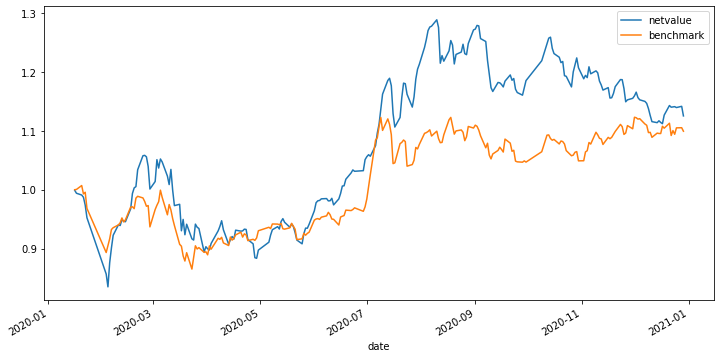

In [23]:
bt_baseline = BackTest(df_predict, n=50, freq=10)
print ("Baseline performance:")
display(bt_baseline.evaluation())
bt_baseline.plot()

**It can be observed that the baseline model perform just as good as our benchmark index 000001.SH.**

Now let's see what we can do adding the mystery of CNN structure.

## Part IV: Feature Engineering

It is assumed that the past trading information heralds future return. The two-dimensional feature of CNN is desirable for this task because data pictures contain different kinds of variables and their time variation. However, traditional CNN, which recognizes local pattern of data input, has troubles in developing models due to its sensitivity to the arrangement of data input. How variables are compiled changes the local patterns, resulting in different ensuing features in modelling. To avoid this drawback, we manually program to extract commonly-used features from data pictures. The following is our list of custom functions. 

In [1]:
%%html
<style> 
table td, table th, table tr {text-align:left !important;}
</style>

$$\text{Table 1. List of Functions and Their Description}$$

Function | Description | Mapping Example
-|:- | -:
ts_corr|compute the correlations between rows|(n,9,30)->(n,36,3)
ts_cov|compute the covariance between rows|(n,9,30)->(n,36,3)
ts_mean|compute the mean of blocks in each row|(n,9,30)->(n,9,3)
ts_stddev|compute the standard deviation of blocks in each row|(n,9,30)->(n,9,3)
ts_zscore|compute the zscore (mean over std.dev.) of blocks in each row|(n,9,30)->(n,9,3)
ts_return|compute the return of blocks in each row|(n,9,30)->(n,9,3)
ts_decaylinear|compute the weighted average (with decaying weights) of blocks in each row|(n,9,30)->(n,9,3)

Note: The parameters are mutable. By default, the span of function and stride are 10. 

The functions in Table 1 can be divided into two types. The first type measures the relationship between rows. The second type computes the statistics of each rows.

Type One: ts_corr, ts_cov

Type Two: ts_mean, ts_stddev, ts_zscore, ts_return, ts_decaylinear

<img src="https://z3.ax1x.com/2021/07/23/WsQEVA.png" style="" width="600">

<img src="https://z3.ax1x.com/2021/07/23/WsQNGV.png" style="" width="600">

**Batch Normalization:**

$$\text{Batch Mean : } \mu = \frac{1}{m} \sum_{l=0}^m Z^{l(i)}$$

$$\text{Batch Std. Dev. : } \sigma^2 = \frac{1}{m} \sum_{i=0}^m (Z^{l(i)}-\mu)^2$$

$$\text{Normalized Result : } \hat Z^{l(i)} = (Z^{l(i)} - \mu)/\sigma$$

where $Z^{l}$ denotes the layer and $Z^{l(i)}$ denotes the elements in the layer.

*List of Pooling Layer**

$$\text{Table 2. List of Pooling Functions and Their Description}$$

Function | Description | Mapping Example
-|- | -
mean|compute the mean of blocks in each row|(n,k,3)->(n,k)
max|compute the max of blocks in each row|(n,k,3)->(n,k)
min|compute the min of blocks in each row|(n,k,3)->(n,k)

**Pipeline Structure**

The realization of figure 2 is more like a combined pipeline function described below.

<img src="https://z3.ax1x.com/2021/07/23/Wrg3RK.png" style="" width="600">

<b>`All the python code is reported in feature_extraction_file.py in the attachment.`</b>

In [40]:
import feature_extraction_file as file

result=file.pipeline(np.array(X[0:2]))

result.shape

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 430.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 601.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 501.59it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1504.95it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 1502.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 175.58it/s]

filter number 0 is starting
pooling number 0 is starting
pooling number 1 is starting
pooling number 2 is starting
filter number 0 finished


filter number 1 is starting
pooling number 0 is starting
pooling number 1 is starting
pooling number 2 is starting
filter number 1 finished


filter number 2 is starting
pooling number 0 is starting
pooling number 1 is starting
pooling number 2 is starting
filter number 2 finished


filter number 3 is starting
pooling number 0 is starting
pooling number 1 is starting
pooling number 2 is starting
filter number 3 finished


filter number 4 is starting
pooling number 0 is starting
pooling number 1 is starting
pooling number 2 is starting
filter number 4 finished


filter number 5 is starting
pooling number 0 is starting
pooling number 1 is starting
pooling number 2 is starting
filter number 5 finished


filter number 6 is starting
pooling number 0 is starting
pooling number 1 is starting
pooling number 2 is starting
filter number 6 finished




(2, 351)

## Part V: Neural Network Architecture

### CNN Model Structure
The network architecture is feature input layers + fully connected dense layer. The model structure of Stock-Selector-Alpha is shown below. 

After feature engineering layers, StockSelector-Alpha will flatten all features, disgarding the temporal information. 

The flattened features are then fed into a dense layer with 64 units. The number of neurons in the hidden layer is not restrained, but the literature recommends setting it at an even power of 2, such as 64, 32, etc. for accelerating GPU/CPU calculations (Vanhoucke and Senior, 2011), and hence the 64 units.

<img src="model.png" style="" width="900">

#### Training Configuration
The activation function for the dense layer is the linear rectified unit (ReLU), whose derivative is easy to compute.

The optimizer is a SGD algorithm called Adam, which is an extended version of SGD proposed by Kingma and Ba (2017).

The learning rate is 0.002



#### Regularization
Neural networks are extremely easy to overfit and regularization is indispensable.

We use three regularization methods from the literature to mitigate overfitting - batch normalization, early stopping, and dropout.

##### Early Stopping
Early stopping is that we examine model performances on the validation set and stop training whenever we observe that model performances on the validation set stop improving. Typically, models will stop improving on the validation set earlier than on the training set, so it is named "Early Stopping".

##### Batch Normalization
The rationale behind batch normalization is that Adam randomly selects a batch of observations and only uses that batch of data for gradient updating in every optimization round, because computing gradients for all observations is costly and unnecessary. Hence, sample draws may have heterogeneous distributions.  In order to sterilize the impact of heterogeneous random draws, we normalize the random batch after the input layer and between each fully connected hidden layer. The specific operations are to first subtract the mean and then divide the square root of batch variance.

##### Dropout
Dropout is a technique that literally “drop out” a certain portion of neurons. Dropout is a potent regularization method and has proved its value in computer vision. This can prevent the networks from getting too convoluted by randomly setting a specific proportion of neurons in each layer to 0. The dropout rate in the input layer is 20%, and in the hidden layer is 50%. It needs to be particularly emphasized that we enlarge the number of neurons accordingly. we adjust the number of neurons to be the original neuron number dividing the dropout rate. For example, if the dropout rate is 50% and the original number of neurons is 32, then the new number of neurons is 52/0.5 = 64.



Code for the CNN model:

In [41]:
class StockSelectorAlpha:
    # StockSelector Alpha
    # Feature Extraction Layer + Dense Layer

    def __init__(self, name, config, fit_config):
        self.name = name
        self.config = config
        self.fit_config = fit_config

        tf.random.set_seed(1)
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape=(351,)),
            tf.keras.layers.Dropout(rate=0.2),  # drop out 20% of the input
            tf.keras.layers.BatchNormalization(),  # normalize data

            tf.keras.layers.Dense(units=64, activation='relu',
                                  kernel_initializer=tf.keras.initializers.TruncatedNormal()),
            tf.keras.layers.Dropout(rate=0.5),  # drop out 50% of the neurons
            tf.keras.layers.BatchNormalization(),  # normalize data
            tf.keras.layers.Dense(units=1, kernel_initializer=tf.keras.initializers.TruncatedNormal())
        ])
        earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=33,
                                                     verbose=0, mode="min", baseline=None,
                                                     restore_best_weights=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(config['model_path'], monitor='val_loss', verbose=0,
                                                        save_best_only=True, mode='min')
        self.cb_list = [earlystop, checkpoint]
        opt = tf.keras.optimizers.Adam(lr=self.config['learning_rate'], clipvalue=0.5)
        self.model.compile(loss=self.config['loss'], optimizer=opt, metrics=self.config['metrics'])

    def fit(self, x, y, validation_data):
        self.model.fit(
            x=x,
            y=y,
            validation_data=(validation_data),
            callbacks=self.cb_list,
            **self.fit_config
        )

    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        return y_pred

    def save(self, path, name):
        if not os.path.exists(path):
            os.mkdir(path)
        self.model.save(path + name + '.h5')
        pd.DataFrame(self.model.history.history).to_csv(path + name + '_train_history.csv')

Code for configuration, training and predicting:

25% of the in-sample data are used for validation and early stopping

In [ ]:
# configuration
config = {
    'model_path': Path('models'),
    'feat_num': 351,
    'learning_rate': 0.002,
    'loss': 'mse',
    'metrics': 'mse',
}

fit_config = {
    'batch_size': 2560,
    'epochs': 10000,
}

# load and prepare data for training and validating
dir_ = Path("data")
with open(dir_ / 'x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open(dir_ / "y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

_train_data = pd.DataFrame(
    np.concatenate((x_train, y_train.reshape(-1, 1)), axis=1)).dropna()  # drop na values in the X and Y
_train_data = _train_data.sample(frac=1, random_state=1)
thr = round(_train_data.shape[0] * 0.75)
train_data = _train_data.iloc[:thr, :]
x_train2 = train_data.iloc[:, :351]
y_train2 = train_data.iloc[:, 351]

val_data = _train_data.iloc[thr:, :]
x_val, y_val = val_data.iloc[:, :351], val_data.iloc[:, 351]

# %%
# Train model
date_str = datetime.datetime.today().strftime("%Y%m%d-%H%M")
selector_to_train = StockSelectorAlpha('stock_selector_on_%s' % date_str, config, fit_config)
selector_to_train.fit(x_train2, y_train2, validation_data=(x_val, y_val))
selector_to_train.save('models/', selector_to_train.name)

# %%
# Make predictions
with open(dir_ / 'x_pred.pkl', 'rb') as f:
    x_pred = pickle.load(f)
with open(dir_ / 'id_pred.pkl', 'rb') as f:
    id_pred = pickle.load(f)
pred_data = pd.DataFrame(np.concatenate((x_pred, id_pred), axis=1)).dropna()
x_pred2 = pred_data.iloc[:, :351]
id_pred2 = pred_data.iloc[:, 351:]

selector_to_predict = tf.keras.models.load_model(os.path.join('models', 'stock_selector_on_20210722-2311.h5'))
y_pred = selector_to_predict.predict(x_pred2)
df_pred = pd.DataFrame(np.concatenate((id_pred2, y_pred), axis=1), columns=['stockid', 'date', 'score']).set_index(
    ['stockid', 'date']).swaplevel().sort_index()
df_pred.to_parquet('prediction_20200701_20201231.parquet')

### Compare: LSTM Model
The CNN version forgoes the temporal informaiton embeded in the feature map. We gauge that there might be great potential in exploiting the information carried in the sequence.

Therefore, the beta version use a recurrent neural network - LSTM to leverage temporal sequnces.

Different from the Dense layers, the input shape of the LSTM network is (observations, time, features). 

We don't do any feature engineering. Instead, we directly input the data picture, whose dimension is time*features, to the LSTM layers. 

The input features are price and volume features including open, high, low, close, turnver, etc. 

<img src="LSTM.png" style="" width="900">

Code for the LSTM model:

In [27]:
class LSTM_model:
    # StockSelector Beta
    # LSTM Layer + Dense Layer

    def __init__(self, name, config, fit_config):
        self.name = "lstm_" + name
        self.config = config
        self.fit_config = fit_config

        tf.random.set_seed(1)
        self.model = tf.keras.Sequential([
            tf.keras.Input(shape=(9, 30)),
            tf.keras.layers.Dropout(rate=0.2),    # drop out 20% of the input
            tf.keras.layers.BatchNormalization(),  # normalize data
            # Shape [batch, time, features] => [batch, time, lstm_units]
            tf.keras.layers.LSTM(64, return_sequences=False, recurrent_dropout=0.5),   # drop out 50% of the input
            # Shape => [batch, time, features]
            tf.keras.layers.Dense(units=64, activation='relu',
                                  kernel_initializer=tf.keras.initializers.TruncatedNormal()),
            tf.keras.layers.Dense(units=1, kernel_initializer=tf.keras.initializers.TruncatedNormal())
        ])
        earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=33,
                                                     verbose=0, mode="min", baseline=None,
                                                     restore_best_weights=True)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(config['model_path'], monitor='val_loss', verbose=0,
                                                        save_best_only=True, mode='min')
        self.cb_list = [earlystop, checkpoint]
        opt = tf.keras.optimizers.Adam(lr=self.config['learning_rate'], clipvalue=0.5)

        if len(tf.config.experimental.list_physical_devices('GPU')) == 0:
            self.GPU = False
            self.model.compile(loss=self.config['loss'], optimizer=opt, metrics=self.config['metrics'])
        else:
            self.GPU = True
            self.model.compile(loss=self.config['loss'], optimizer=opt, metrics=self.config['metrics'])

    def fit(self, x, y, validation_data=None):
        self.model.fit(
            x=x,
            y=y,
            validation_data=(validation_data),
            callbacks=self.cb_list,
            **self.fit_config
        )

    def predict(self, x_test):
        y_pred = self.model.predict(x_test)
        return y_pred